In [46]:
# Import packages
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import socket 

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [47]:
%load_ext dotenv
%dotenv ../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [48]:
con = create_engine(os.getenv('EDM_DATA'))

In [49]:
# Specify latest PLUTO version
pluto = 'dcp_pluto."19v2_wo_corrections"'
# Specify previous PLUTO version or the one you want to compare to
plutoprev = 'dcp_pluto."19v1"'

In [50]:
sql = '''
SELECT  sum(UnitsRes::numeric) as UnitsRes,
        sum(LotArea::numeric) as LotArea,
        sum(BldgArea::numeric) as BldgArea,
        sum(ComArea::numeric) as ComArea,
        sum(ResArea::numeric) as ResArea,
        sum(OfficeArea::numeric) as OfficeArea,
        sum(RetailArea::numeric) as RetailArea,
        sum(GarageArea::numeric) as GarageArea,
        sum(StrgeArea::numeric) as StrgeArea,
        sum(FactryArea::numeric) as FactryArea,
        sum(OtherArea::numeric) as OtherArea,
        sum(AssessLand::numeric) as AssessLand,
        sum(AssessTot::numeric) as AssessTot,
        sum(ExemptTot::numeric) as ExemptTot,
        sum(FIRM07_FLAG::numeric) as FIRM07_FLAG,
        sum(PFIRM15_FLAG::numeric) as PFIRM15_FLAG
FROM {}
'''

In [51]:
df = pd.read_sql(sql=sql.format(pluto), con=con)
df_prev = pd.read_sql(sql=sql.format(plutoprev), con=con)

In [52]:
old = pd.read_csv('https://raw.githubusercontent.com/NYCPlanning/db-pluto-qaqc/master/19v1/19v1-18v2.1-18v1-aggregate_value_comparison.csv', index_col=False)

In [53]:
old = old.iloc[1:-1, 1:]

In [54]:
old = old.drop(['ExemptLand'], axis=1)

In [55]:
old.columns = [i.lower() for i in old.columns]

In [56]:
df['version'] = '19v2_beta'
df_prev['version'] = '19v1'

In [57]:
summary = pd.concat([old, df_prev,df], sort=False)
summary.index = summary.version
summary_pct = summary.iloc[:, 1:].pct_change()

In [58]:
summary

,version,unitsres,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,assessland,assesstot,exempttot,firm07_flag,pfirm15_flag
version,,,,,,,,,,,,,,,,,
18v2.1,18v2.1,3572157.0,6.813542e+09,5.504286e+09,1.820455e+09,3.477582e+09,654410227.0,276896354.0,120942956.0,100257225.0,116612843.0,524200834.0,9.782664e+10,3.936520e+11,1.446245e+11,34683.0,65688.0
19v1,19v1,3586812.0,6.834645e+09,5.653032e+09,1.826705e+09,3.488868e+09,658072038.0,276439866.0,121187685.0,99741648.0,116551945.0,527119842.0,1.065292e+11,4.509298e+11,1.507207e+11,34695.0,65712.0
19v2_beta,19v2_beta,3684312.0,6.790395e+09,5.869464e+09,1.826876e+09,3.492699e+09,664984078.0,276805014.0,121136049.0,91503422.0,117046684.0,526731143.0,1.065292e+11,4.509298e+11,1.507207e+11,34691.0,65717.0


In [59]:
summary_pct

,unitsres,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,assessland,assesstot,exempttot,firm07_flag,pfirm15_flag
version,,,,,,,,,,,,,,,,
18v2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19v1,0.004103,0.003097,0.027024,0.003433,0.003245,0.005596,-0.001649,0.002024,-0.005143,-0.000522,0.005568,0.088959,0.145504,0.042152,0.000346,0.000365
19v2_beta,0.027183,-0.006474,0.038286,0.000094,0.001098,0.010503,0.001321,-0.000426,-0.082596,0.004245,-0.000737,0.000000,0.000000,0.000000,-0.000115,0.000076


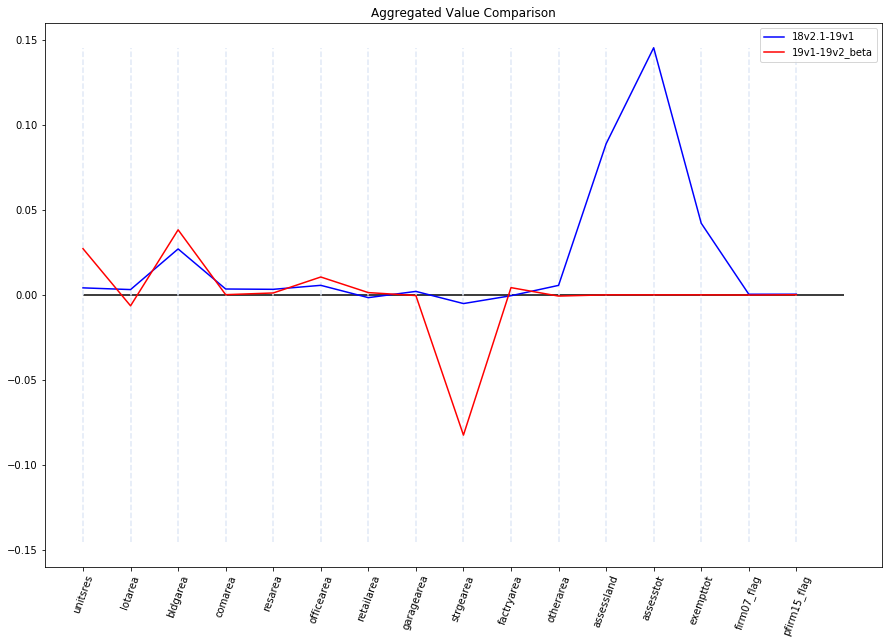

In [60]:
plt.figure(figsize=(15, 10))
plt.plot(range(16), summary_pct.iloc[1, :], color = 'blue', label='18v2.1-19v1')
plt.plot(range(16), summary_pct.iloc[2, :], color = 'red', label='19v1-19v2_beta')
plt.hlines(0, 16, 0) #0 reference line
for i in range(16):
    plt.vlines(i, min(-summary_pct.iloc[1, :]), max(summary_pct.iloc[1, :]), color = '#e1e9f7', linestyles='dashed')
plt.xticks(range(16), summary_pct.columns, rotation=70)
plt.title('Aggregated Value Comparison')
plt.legend()
plt.show()